Model:
for any grid data set spanning one year, give average daily cost and CO2 emission of operating H2 gas station and battery charging station, using average delivered cost and CO2 per kWh from infopack

set global variables and import from excel file
import: 
- demand/hr for H2 cars (modeled off of gas cars)
- demand/hr for BEVs (overnight charging)

functions we need:
1. **hourly_values_per_kWh(hourly_composition, source_list, infopack, min_or_max)** - using the list of source values per hour, and list of sources in this data set, and values for cost and CO2/kWh for each source and a list of bools representing min (False) or max(True) values to use for every type of energy, give cost/kWh and CO2/kWh for each hour in a year
2. **battery_charging(battery_demand, hourly_values, BEV_params)** - using static model of demand/hour, and list of cost and CO2/kWh for each hour, return list of kWh used per hour FOR BATTERY CARS
3. **H2_charging(H2_demand, hourly_values, H2_parameters, CO2_or_cost)** - using:
    - static model of demand/hour, 
    - kWh per kgH2 electrolysis + compresison, size of station H2 tank, 
    - list of cost and CO2/kWh for each hour, 
    - and string "CO2" or "cost" 
    return kWh used per hour, optimized for either CO2 emissions or cost FOR H2 CARS
4. **hourly_kWh_to_stats(kWh_per_h, hourly_values)** - using kWh used per hour over 1 year, return average daily cost and CO2 over 1 year

In [1]:
import pandas as pd, pickle

# prepare datapack info for hourly_values_per_kWh function
sources_excel = pd.read_excel(r"use_phase_model.xlsx", sheet_name ="SourceValsPython")
cols = len(sources_excel.columns)
sources_vals = [[sources_excel.columns[i]] + list(sources_excel.iloc[:,i]) for i in range(cols)]

# prepare ontario dataset for hourly_values_per_kWh function (values are in MWh)
ontario_excel = pd.read_excel(r"use_phase_model.xlsx", sheet_name ="Ontario", skiprows = 2)
ontario_source_list = list(ontario_excel.columns)[2:-1]
ontario_source_list[4] = "Solar (PV)"
ontario_hourly_comp = [[ontario_excel.loc[i][0].isoformat("-")[:-8]+str(ontario_excel.loc[i][1])] + \
                       list(ontario_excel.loc[i][2:-1]) for i in range(1,len(ontario_excel))]

# load california dataset for hourly_values_per_kWh function, add together biomass and biogas columns
# (values are MWh)
california_source_list = ("Day-Hour", 'GEOTHERMAL', 'BIOFUEL', 'SMALL HYDRO', 'WIND', 'SOLAR (PV)', \
           'SOLAR (THERMAL)', 'NUCLEAR', 'THERMAL', 'IMPORTS', 'HYDRO')

# pkl file prepared by webscraping in california_power_hourly notebook
f = open("Cali_Data/00total.pkl", "rb")
california_hourly_comp_ints = [[hour[0]] + [int(val) for val in hour[1:]] for hour in pickle.load(f)]
california_hourly_comp = [i[:2]+[i[2]+i[3]]+i[4:] for i in california_hourly_comp_ints]
f.close()

#prepare H2_params and BEV_params for H2_charging function
station_excel = pd.read_excel(r"use_phase_model.xlsx", sheet_name ="ParametersPython")
H2_params = [list(station_excel.iloc[i]) for i in range(4)]
BEV_params = [list(station_excel.iloc[i]) for i in range(4,5)]

#prepare H2_demand and battery_demand
demand_excel = pd.read_excel(r"use_phase_model.xlsx", sheet_name ="DemandPython", header=None)
H2_demand = [list(demand_excel.iloc[i]) for i in range(2)]
battery_demand = [list(demand_excel.iloc[i]) for i in range(2,4)]

[['Station efficiency', 44.47006821913829, 59.29342429218439, 'kWh/kgH2'], ['H2 mass needed for one day', 386.1003861003862, 450.45045045045055, 'kg'], ['max rate of electrolysis', 2000.0, 1500.0, 'kW'], ['station tank capacity', 692.5058312371369, 346.25291561856847, 'kg']]


In [2]:
def hourly_values_per_kWh(hourly_comp, source_list, infopack, min_or_max):
    if len(min_or_max) != len(source_list): 
        print("Warning: list of bools min_or_max and source_list not same length")
    
    matched_sources = []
    ignored_cols = []
    for source_ind in range(1, len(source_list)):
        match = False
        for source in infopack[2:]:
            if source[0].upper() == source_list[source_ind].upper():
                matched_sources.append(source)
                match = True
        if match == False: 
            print("Warning: No infopack entry found for source: "+ source_list[source_ind] + \
                  ". It will be ignored.")
            ignored_cols.append(source_ind)
    
    hourly_values = []
    for hour in hourly_comp:
        total_kWh = 0
        total_CO2 = 0
        total_cost = 0
        for source_ind in range(len(matched_sources)):
            source_kWh = 1000 * hour[source_ind+1]
            total_kWh += source_kWh
            total_cost += source_kWh * matched_sources[source_ind][1+min_or_max[source_ind]]
            total_CO2 += source_kWh * matched_sources[source_ind][3+min_or_max[source_ind]]
        
        # calculate hourly cost and CO2 per kWh
#         hourly_values.append((total_CO2/total_kWh, total_cost/total_kWh))
        hourly_values.append((total_cost/total_kWh, total_CO2/total_kWh))
    
    return hourly_values

def battery_charging(battery_demand, hourly_values, BEV_params):
    kWh_per_h = []
    for i in (0,1): 
        kWh_per_h.append([])
        for hour in range(len(hourly_values)):
            hourly_energy = BEV_params[0][i+1] * battery_demand[1][(hour%24)+1] / 100
            kWh_per_h[i].append(hourly_energy)
    return kWh_per_h

# def H2_charging(H2_demand, hourly_values, H2_params, CO2_or_cost):
    
#     station_efficiency = H2_params[0][1:3]
#     daily_total_H2 = H2_params[1][1:3]
#     kWh_per_h = []
#     for i in (0,1): 
#         kWh_per_h.append([])
#         for hour in range(len(hourly_values)):
#             hourly_energy = station_efficiency[i] * daily_total_H2[i] * H2_demand[1][(hour%24)+1]/ 100
#             kWh_per_h.append(hourly_energy)
#     return kWh_per_h

def H2_charging(H2_demand, hourly_values, H2_params, opt_for):
   
    station_efficiency = H2_params[0][1:3]
    daily_total_H2 = H2_params[1][1:3]
    electrolysis_rate = H2_params[2][1:3]
    tank_size = H2_params[3][1:3]
    kWh_per_h = []
    
    if opt_for == "CO2":
        CO2_or_cost = 0
    elif opt_for == "cost":
        CO2_or_cost = 1
    else: print("opt_for must be either 'CO2' or 'cost'")
    
    for i in (0,1): 
        tank_amount = 0
        kWh_per_h.append([])
        for hour in range(len(hourly_values)):
            hourly_demand = daily_total_H2[i] * H2_demand[1][(hour%24)+1]/ 100
            
            if hour < 12: window_min = 0
            else: window_min = hour-6
                
            if hour-len(hourly_values) < 12: window_max = len(hourly_values)
            else: window_max = hour+6
            
            if ((hourly_values[hour][CO2_or_cost] < (sum(hourly_values[window_min:window_max][CO2_or_cost])\
                                                    /len(hourly_values[window_min:window_max][CO2_or_cost]))) or \
            (tank_amount < (tank_size[i]/4))) \
            and (tank_amount + (electrolysis_rate[i] / station_efficiency[i]))<tank_size[i]:
                hourly_energy = electrolysis_rate[i]
                tank_amount += electrolysis_rate[i] / station_efficiency[i]
            else:
                hourly_energy = 0
            
            tank_amount -= hourly_demand
            if tank_amount < 0: 
                print("Warning: negative tank amount. Simulation ended on hour:" + str(hour))
                break
            
            kWh_per_h[i].append((hourly_energy))
    return kWh_per_h

def hourly_kWh_to_stats(kWh_per_h, hourly_values):
    # returns list of min and max values, each containing daily avg CO2 and cost
    # and hourly averages of CO2 and cost
    num_hours = len(kWh_per_h[0])
    best_worst_stats = []
    
    for best_worst in (0,1):
        hourly_CO2 = [0 for i in range(24)]
        hourly_cost = [0 for i in range(24)]
        
        for hour in range(num_hours):
            hourly_CO2[hour%24] += kWh_per_h[best_worst][hour] * hourly_values[hour][0]
            hourly_cost[hour%24] += kWh_per_h[best_worst][hour] * hourly_values[hour][1]
            
        daily_avg_CO2 = sum(hourly_CO2)*24/num_hours
        daily_avg_cost = sum(hourly_cost)*24/num_hours
        
        hourly_avg_CO2 = [hour_total/(num_hours/24) for hour_total in hourly_CO2]
        hourly_avg_cost = [hour_total/(num_hours/24) for hour_total in hourly_cost]
        
        best_worst_stats.append((daily_avg_CO2, daily_avg_cost, hourly_avg_CO2, hourly_avg_cost))
    
    
    return best_worst_stats


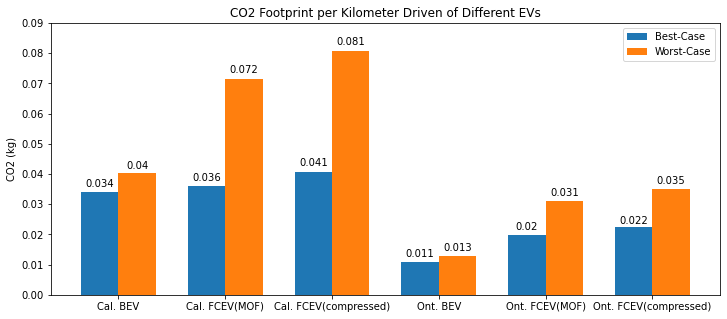

(0.0, 0.27)

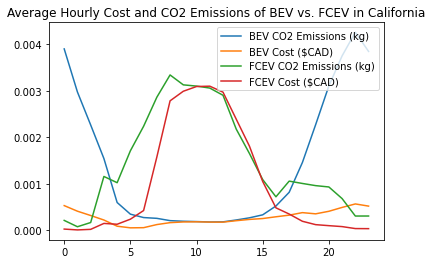

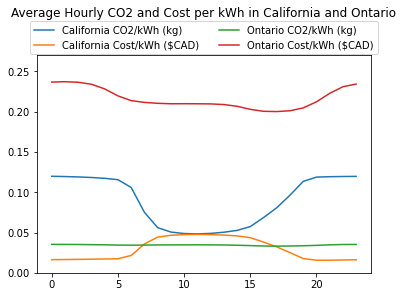

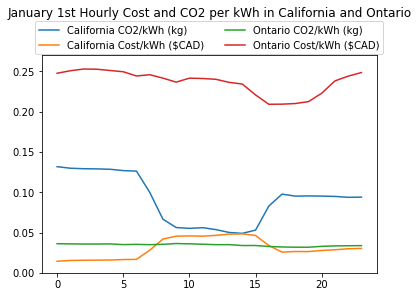

In [3]:
import matplotlib.pyplot as plt, numpy as np

MOF_comp_ratio = 1.13

hourly_vals_cali = hourly_values_per_kWh(california_hourly_comp, california_source_list, sources_vals, \
                                         [False for i in range(len(california_source_list))])

hourly_vals_ont = hourly_values_per_kWh(ontario_hourly_comp, ontario_source_list, sources_vals, \
                                         [False for i in range(len(ontario_source_list))])

cali_bev_hourly = battery_charging(battery_demand, hourly_vals_cali, BEV_params)
cali_bev_stats = hourly_kWh_to_stats(cali_bev_hourly, hourly_vals_cali)

cali_H2_hourly = H2_charging(H2_demand, hourly_vals_cali, H2_params, "CO2")
cali_H2_stats = hourly_kWh_to_stats(cali_H2_hourly, hourly_vals_cali)

ont_bev_hourly = battery_charging(battery_demand, hourly_vals_ont, BEV_params)
ont_bev_stats = hourly_kWh_to_stats(ont_bev_hourly, hourly_vals_ont)

ont_H2_hourly = H2_charging(H2_demand, hourly_vals_ont, H2_params, "CO2")
ont_H2_stats = hourly_kWh_to_stats(ont_H2_hourly, hourly_vals_ont)

fact = 1 / (100*300)
ont_H2_stats = [[np.array(array)*fact for array in ont_H2_stats[i]] for i in (0,1)]
ont_bev_stats = [[np.array(array)*fact for array in ont_bev_stats[i]] for i in (0,1)]
cali_H2_stats = [[np.array(array)*fact for array in cali_H2_stats[i]] for i in (0,1)]
cali_bev_stats = [[np.array(array)*fact for array in cali_bev_stats[i]] for i in (0,1)]

labels = ['Cal. BEV', 'Cal. FCEV(MOF)', 'Cal. FCEV(compressed)','Ont. BEV',\
          'Ont. FCEV(MOF)','Ont. FCEV(compressed)']
best_case = [cali_bev_stats[0][0], cali_H2_stats[0][0],cali_H2_stats[0][0]*MOF_comp_ratio , ont_bev_stats[0][0]\
             , ont_H2_stats[0][0], ont_H2_stats[0][0]*MOF_comp_ratio]
worst_case = [cali_bev_stats[1][0], cali_H2_stats[1][0],cali_H2_stats[1][0]*MOF_comp_ratio , ont_bev_stats[1][0]\
              , ont_H2_stats[1][0], ont_H2_stats[1][0]*MOF_comp_ratio]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 5))
rects1 = ax.bar(x - width/2, best_case, width, label='Best-Case')
rects2 = ax.bar(x + width/2, worst_case, width, label='Worst-Case')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('CO2 (kg)')
ax.set_title('CO2 Footprint per Kilometer Driven of Different EVs')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.set_ylim((0,0.09))
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = round(rect.get_height(),3)
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)


# fig.tight_layout()
plt.show()

plt.figure()
plt.plot(cali_bev_stats[0][2])
plt.plot(cali_bev_stats[0][3])
plt.plot(cali_H2_stats[0][2])
plt.plot(cali_H2_stats[0][3])
plt.title("Average Hourly Cost and CO2 Emissions of BEV vs. FCEV in California")
plt.legend(("BEV CO2 Emissions (kg)","BEV Cost ($CAD)", "FCEV CO2 Emissions (kg)","FCEV Cost ($CAD)"))

avg_hourly_cali = hourly_kWh_to_stats([[1 for i in hourly_vals_cali] for j in (min,max)], hourly_vals_cali)[0][2:]
avg_hourly_ont = hourly_kWh_to_stats([[1 for i in hourly_vals_ont] for j in (min,max)], hourly_vals_ont)[0][2:]

plt.figure()
plt.plot(range(24),avg_hourly_cali[0])
plt.plot(avg_hourly_cali[1])
plt.plot(avg_hourly_ont[0])
plt.plot(avg_hourly_ont[1])
plt.title("Average Hourly CO2 and Cost per kWh in California and Ontario",y=1.15)
plt.legend(("California CO2/kWh (kg)","California Cost/kWh ($CAD)", "Ontario CO2/kWh (kg)",\
            "Ontario Cost/kWh ($CAD)"),loc='upper center',bbox_to_anchor=(0.5, 1.18), fancybox=True,ncol = 2)
plt.ylim((0,0.27))

plt.figure()
day_hr = 24*0
plt.plot(range(24), hourly_vals_cali[day_hr:day_hr+24])
plt.plot(hourly_vals_ont[day_hr:day_hr+24])
plt.title("January 1st Hourly Cost and CO2 per kWh in California and Ontario",y=1.15)
plt.legend(("California CO2/kWh (kg)","California Cost/kWh ($CAD)", "Ontario CO2/kWh (kg)",\
            "Ontario Cost/kWh ($CAD)"),loc='upper center',bbox_to_anchor=(0.5, 1.18), fancybox=True,ncol = 2)
plt.ylim((0,0.27))


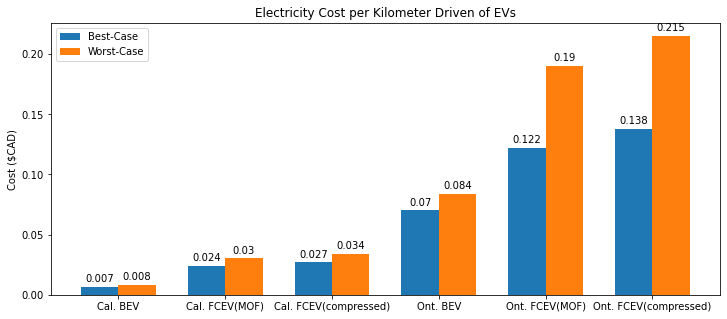

In [8]:
labels = ['Cal. BEV', 'Cal. FCEV(MOF)', 'Cal. FCEV(compressed)','Ont. BEV',\
          'Ont. FCEV(MOF)','Ont. FCEV(compressed)']
best_case = [cali_bev_stats[0][1], cali_H2_stats[0][1],cali_H2_stats[0][1]*MOF_comp_ratio , ont_bev_stats[0][1]\
             , ont_H2_stats[0][1], ont_H2_stats[0][1]*MOF_comp_ratio]
worst_case = [cali_bev_stats[1][1], cali_H2_stats[1][1],cali_H2_stats[1][1]*MOF_comp_ratio , ont_bev_stats[1][1]\
              , ont_H2_stats[1][1], ont_H2_stats[1][1]*MOF_comp_ratio]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 5))
rects1 = ax.bar(x - width/2, best_case, width, label='Best-Case')
rects2 = ax.bar(x + width/2, worst_case, width, label='Worst-Case')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Cost ($CAD)')
ax.set_title('Electricity Cost per Kilometer Driven of EVs')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

autolabel(rects1)
autolabel(rects2)